In [1]:
import sys, os

sys.path.append(os.path.abspath('../'))

import tensorflow as tf
import tensorflow_datasets as tfds
import quarks2cosmos.datasets

In [2]:
%pylab inline
import jax
import numpy as np
import jax.numpy as jnp
from astropy.table import Table

Populating the interactive namespace from numpy and matplotlib


## Load the MassiveNUs dataset

In [3]:
N_BATCH = 10
NOISE_STD = 0.15
N_map = 360

In [4]:
def load_dataset(batch_size, noise_dist_std, train_split):
    def pre_process(example):
        """ Pre-processing function preparing data for denoising task
        """
        # Cutout a portion of the map
        x = tf.expand_dims(example['map'], -1)
        x = tf.image.flip_left_right(x)
        x = tf.image.flip_up_down(x)

        # Apply image reampling to 256x256 but preserving
        x = tf.image.resize(x, [N_map, N_map], method=tf.image.ResizeMethod.AREA)
        # Sample random Gaussian noise
        u = tf.random.normal(tf.shape(x))
        # Sample standard deviation of noise corruption
        s = noise_dist_std * tf.random.normal((1, 1, 1))
        # Create noisy image
        y = x + s * u
        return {'x':x, 'y':y, 'u':u,'s':s}
    ds = tfds.load('MassiveNu', split=train_split)
    ds = ds.map(pre_process)
    ds = ds.batch(batch_size)
    return ds.as_numpy_iterator()

## Theoretical Gaussian prior

In [5]:
dset = load_dataset(N_BATCH, NOISE_STD, tfds.Split.TRAIN)

In [6]:
resolution = 3.5 * 60 / N_map                  # Pixel resolution in arcmin/pixel
pixel_size = np.pi * resolution / 180. / 60. # Pixel resolution in rad/pixel

from quarks2cosmos.lensing import measure_power_spectrum
cl_list = []

for i in range(500):
    m = next(dset)
    kappa_batch = m['x']
    # We can also compute the power spectra of these various maps
    for kappa in kappa_batch:
        ell_measured, cl_measured = measure_power_spectrum(kappa[...,0], pixel_size=pixel_size)
        cl_list.append(cl_measured)
        
cl_measured_arr = jnp.array(cl_list)        

cl_mean = jnp.mean(cl_measured_arr, axis=0)
cl_lower = jnp.percentile(cl_measured_arr, 2.5, axis=0)
cl_upper = jnp.percentile(cl_measured_arr, 97.5, axis=0)

In [7]:
import jax_cosmo as jc

z_sample = 1. + np.random.normal(0.002, size=(10000))
pz = jc.redshift.kde_nz(jnp.array(z_sample),
                        jnp.ones(10000), bw=0.001)

@jax.jit
def theory_cl(ell):
    """ Computes angular C_ell for our survey, at given ell
    """
    cosmo = jc.Planck15()
    tracer = jc.probes.WeakLensing([pz])
    return jc.angular_cl.angular_cl(cosmo, ell, [tracer])[0]

ell = jnp.logspace(2,5)
cl_theory = theory_cl(ell)

/jet/home/supranta/.local/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:5792: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


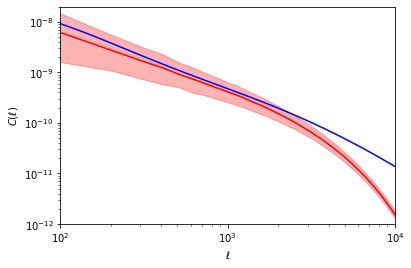

In [88]:
xlabel('$\ell$')
ylabel('$C(\ell)$')
xlim(1e+2,1e+4)
ylim(1e-12,2e-8)
loglog(ell_measured, cl_mean, 'r-')
loglog(ell, cl_theory, 'b')
fill_between(ell_measured, cl_lower, cl_upper, color='r', alpha=0.3)

In [89]:
from quarks2cosmos.lensing import make_power_map

# Computing theory power spectrum
# cl_data = jnp.stack([ell_measured, cl_mean])
cl_data = jnp.stack([ell, cl_theory])

# Build diagonal covariance matrix S
S = make_power_map(cl_data, size=N_map, pixel_size=pixel_size, ell=True)

In [90]:
def log_gaussian_prior(kappa, sigma):
    k_ft = jnp.fft.fft2(kappa) / N_map
    return -0.5*jnp.sum(jnp.real(k_ft*jnp.conj(k_ft)) / (S+sigma[...,0]**2))
gaussian_prior_score = jax.vmap(jax.grad(log_gaussian_prior), in_axes=[0,0])

## Get the score network

In [91]:
# Ok, so now we just need to train 
from quarks2cosmos.models import SmallUResNet, MediumUResNet, SNParamsTree
import haiku as hk
import optax

In [92]:
def forward_fn(x, s, is_training=False):
    denoiser = MediumUResNet()
    return denoiser(x, s, is_training=is_training)

model = hk.transform_with_state(forward_fn)

sn_fn = hk.transform_with_state(lambda x: CustomSNParamsTree(ignore_regex='[^?!.]*b$',val=1)(x))

In [93]:
# model = hk.transform_with_state(lambda x, sigma, is_training=False: SmallUResNet()(x, sigma, is_training))

In [94]:
params, state = model.init(jax.random.PRNGKey(0), 
                           jnp.zeros([1,N_map,N_map,2]),
                           jnp.zeros([1,1,1,1]), is_training=True)

In [95]:
def lr_schedule(step):
    steps_per_epoch = 10000 // N_BATCH

    current_epoch = step / steps_per_epoch  # type: float
    lr = (1.0 * N_BATCH) / 32
    boundaries = jnp.array((20, 40, 60)) * steps_per_epoch
    values = jnp.array([1., 0.1, 0.01, 0.001]) * lr

    index = jnp.sum(boundaries < step)
    return jnp.take(values, index)

In [96]:
optimizer = optax.chain(
  optax.adam(learning_rate=1e-3),
  optax.scale_by_schedule(lr_schedule)
)
rng_seq = hk.PRNGSequence(42)

In [97]:
opt_state = optimizer.init(params)

In [98]:
sn_fn = hk.transform_with_state(lambda x: SNParamsTree(ignore_regex='[^?!.]*b$|[^?!.]*offset$',
                                                          val=1.)(x))

In [99]:
_, sn_state = sn_fn.init(next(rng_seq), params)

In [100]:
params, sn_state = sn_fn.apply(None, sn_state, None, params)

In [101]:
def score_fn(params, state, rng_key, batch, is_training=True):
    # If requested, first compute the Gaussian prior
    gaussian_score = gaussian_prior_score(batch['y'][...,0], batch['s'][...,0])
    gaussian_score = jnp.expand_dims(gaussian_score, axis=-1)
    net_input = jnp.concatenate([batch['y'], jnp.abs(batch['s'])**2 * gaussian_score],axis=-1)
    res, state = model.apply(params, state, rng_key, net_input, batch['s'], is_training=is_training)
    return batch, res, gaussian_score

In [102]:
def loss_fn(params, state, rng_key, batch):
    _, res, gaussian_score = score_fn(params, state, rng_key, batch)
    loss = jnp.mean((batch['u'] + batch['s'] * (res + gaussian_score))**2)
    return loss, state

In [103]:
@jax.jit
def update(params, state, sn_state, rng_key, opt_state, batch):
    (loss, state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, state, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    new_params, new_sn_state = sn_fn.apply(None, sn_state, None, new_params)
    return loss, new_params, state, new_sn_state, new_opt_state

In [104]:
import pickle

In [105]:
N_BATCH = 50
NOISE_STD = 0.2

In [192]:
%%time

dset = load_dataset(N_BATCH, NOISE_STD, tfds.Split.TRAIN)

CPU times: user 82.8 ms, sys: 27.2 ms, total: 110 ms
Wall time: 11.8 s


In [193]:
# with open('../models/dm_score_hybrid_medium/model-16000.pckl', 'rb') as file:
#     params, state, sn_state = pickle.load(file)

1001 0.031009184
1051 0.01632919
1101 0.04416868
1151 0.034993842


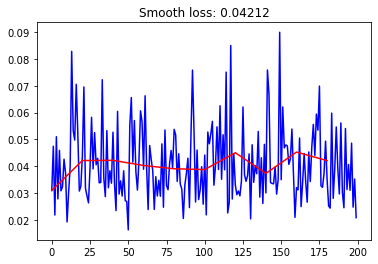

Loading dataset...
1201 0.029621696
1251 0.045478996
1301 0.043400116
1351 0.025410192


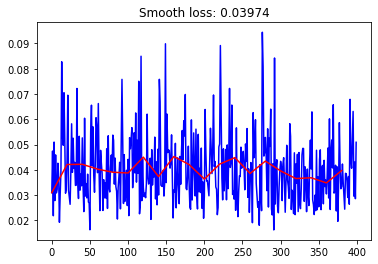

Loading dataset...
1401 0.026762271
1451 0.0353377
1501 0.04862439
1551 0.032509923


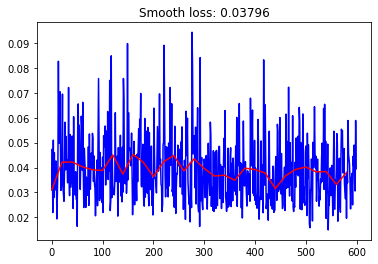

Loading dataset...
1601 0.0549582
1651 0.035150357
1701 0.045407295
1751 0.033686295


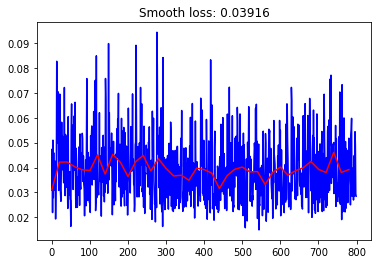

Loading dataset...
1801 0.0430063
1851 0.01862985
1901 0.037022255
1951 0.029048344


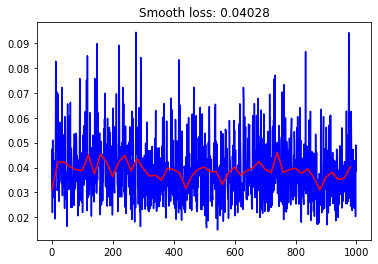

Loading dataset...
2001 0.054486863
2051 0.020851051
2101 0.04062238
2151 0.03617198


In [ ]:
losses = []
smoothed_losses = []

for step in range(1001,60000):
    loss, params, state, sn_state, opt_state = update(params, state, sn_state,
                                                      next(rng_seq), opt_state,
                                                      next(dset))
    losses.append(loss)
    if((step-1)%20==0):
        smooth_loss = np.array(losses[-20:]).mean()
        smoothed_losses.append(smooth_loss)
    if (step-1)%50==0:
        print(step, loss)
  
    if step%(10000//N_BATCH) ==0:
        title("Smooth loss: %2.5f"%(smooth_loss))
        plot(np.array(losses), 'b-')
        plot(20. * np.arange(len(smoothed_losses)), np.array(smoothed_losses), 'r-')
        show()    
        print("Loading dataset...")
        dset = load_dataset(N_BATCH, NOISE_STD, tfds.Split.TRAIN)
    if(step%1000==0):
        with open('../models/dm_score_hybrid_theory/model-%d.pckl'%step, 'wb') as file:            
            pickle.dump([params, state, sn_state], file)

In [ ]:
with open('../models/dm_score_hybrid_medium/model-final.pckl', 'wb') as file:
    pickle.dump([params, state, sn_state], file)

In [128]:
batch = next(dset)

In [129]:
def plot_maps(maps):
    true_map, noisy_map, score, denoised_map = maps
    
    figure(figsize=(16,4))
    subplot(141)
    title("%0.3f"%batch['s'][ind,0,0,0])
    imshow(true_map,cmap='magma',vmin=-0.05,vmax=0.3)
    axis('off')
    subplot(142)
    imshow(noisy_map, cmap='magma',vmin=-0.05,vmax=0.3)
    axis('off')
    subplot(143)
    imshow(score, cmap='magma')
    axis('off')
    subplot(144)
    imshow(denoised_map,cmap='magma',vmin=-0.05,vmax=0.3)
    axis('off')
    
def plot_1pt_ps(maps):
    true_map, noisy_map, _, denoised_map = maps 

    ell, ps_true     = measure_power_spectrum(true_map, pixel_size=pixel_size)
    ell, ps_noisy    = measure_power_spectrum(noisy_map, pixel_size=pixel_size)
    ell, ps_denoised = measure_power_spectrum(denoised_map, pixel_size=pixel_size)

    kappa_bins = np.linspace(-0.05, 0.10, 200)
    kappa_bin_centre = 0.5 * (kappa_bins[1:] + kappa_bins[:-1])

    true_hist, _     = np.histogram(true_map.flatten(), bins=kappa_bins, density=True)
    denoised_hist, _ = np.histogram(denoised_map.flatten(), bins=kappa_bins, density=True)
    noisy_hist, _    = np.histogram(noisy_map.flatten(), bins=kappa_bins, density=True)

    figure(figsize=[10,3.5])
    subplot(121)
    xlim(-0.05, 0.1)
    ylim(-0.01, 50.)
    xlabel('$\kappa$')
    ylabel('$P(\kappa)$')
    title('1 pt function')
    plot(kappa_bin_centre, true_hist, color='r', label='True map')
    plot(kappa_bin_centre, denoised_hist, color='b', label='Denoised map')
    plot(kappa_bin_centre, noisy_hist, color='g', label='Noisy map')
    legend()
    subplot(122)
    xlabel('$\ell$')
    ylabel('$C(\ell)$')
    title('Power spectrum')
    ylim(1e-12,2e-8)
    loglog(ell, ps_true, 'r', label='True map')
    loglog(ell, ps_denoised, 'b', label='Denoised map')
    loglog(ell, ps_noisy, 'g',  label='Noisy map')
    legend()
    show()        

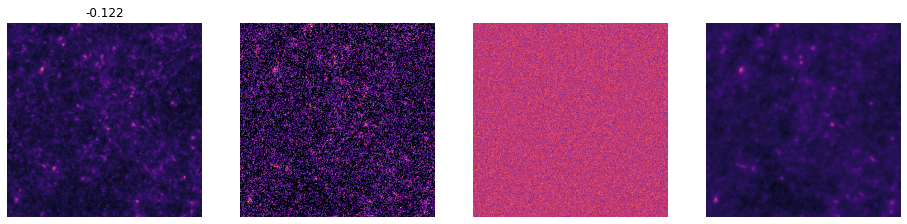

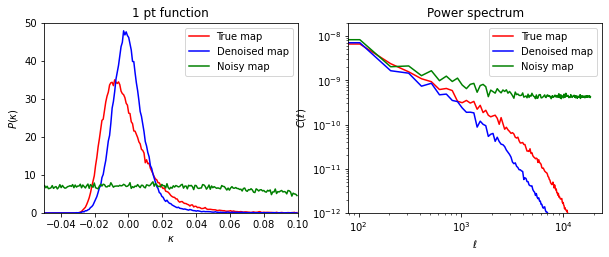

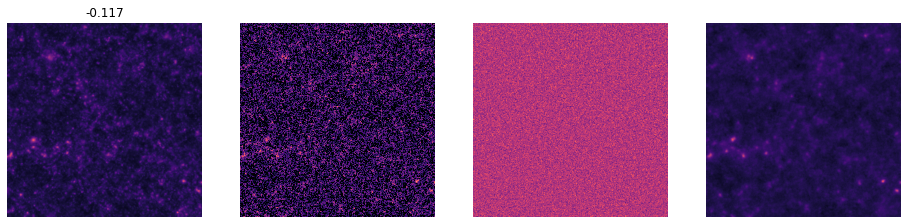

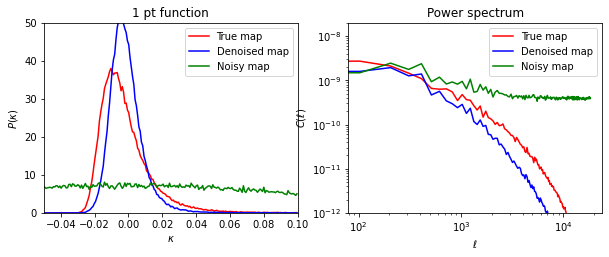

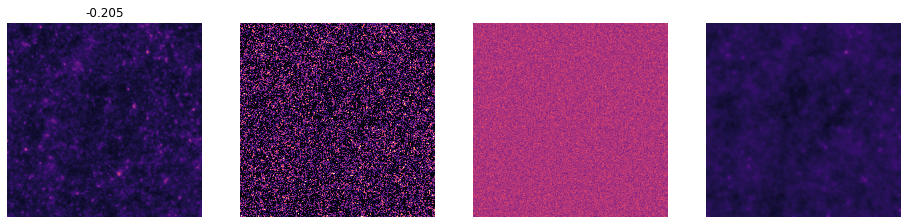

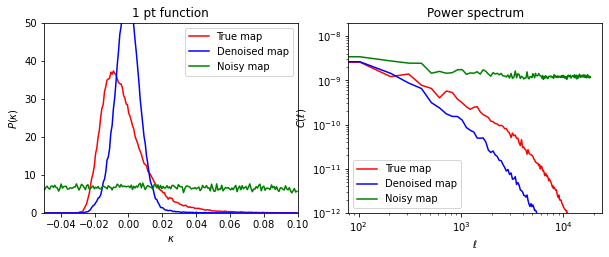

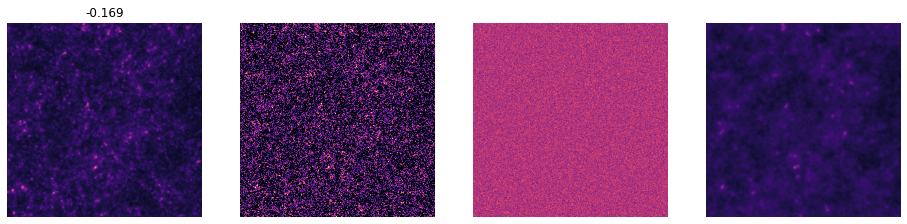

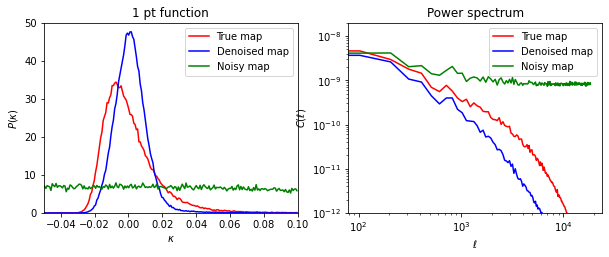

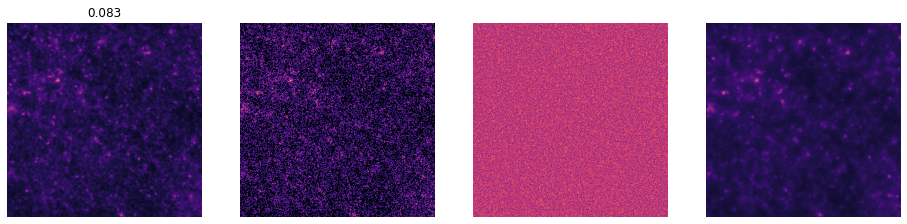

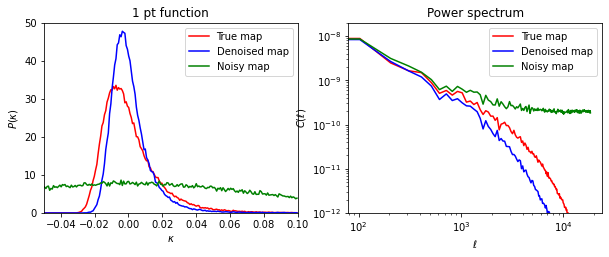

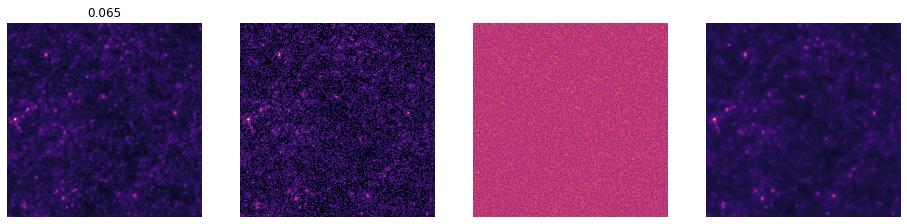

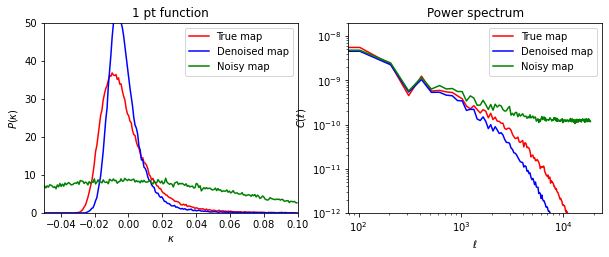

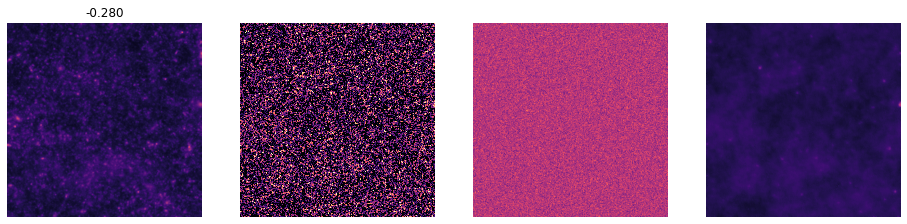

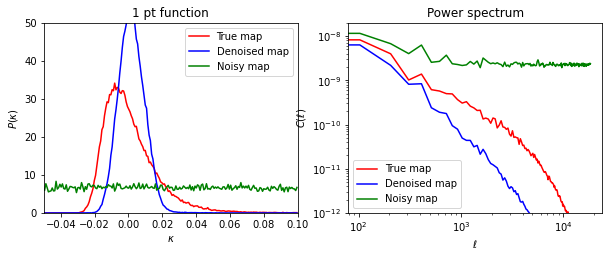

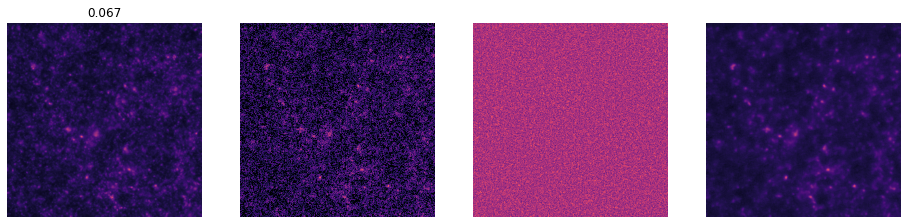

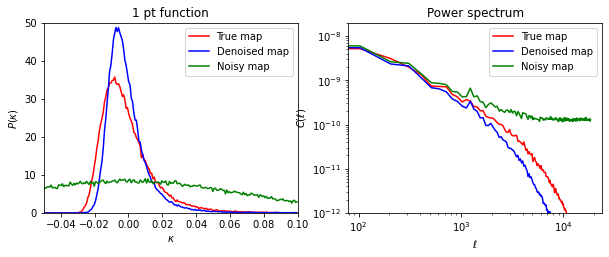

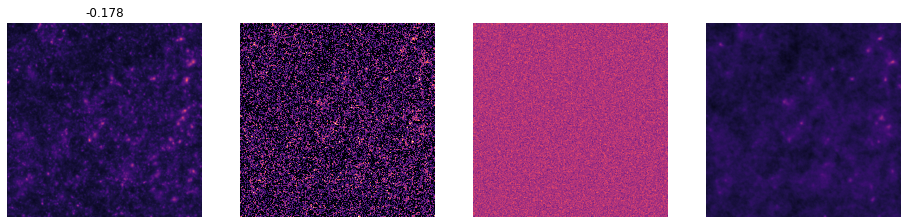

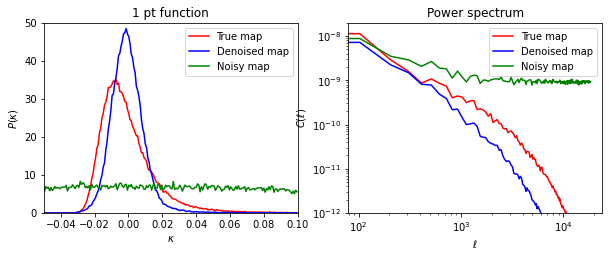

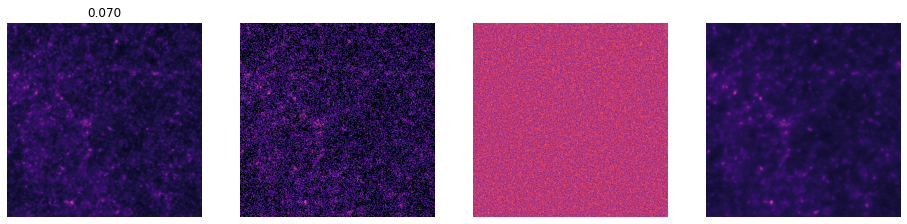

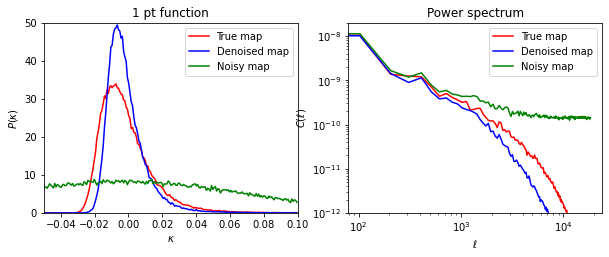

In [130]:
_, res, gaussian_score = score_fn(params, state, next(rng_seq), batch)

for i in range(10):
    ind = i
    
    true_map = batch['x'][ind,...,0]
    noisy_map = batch['y'][ind,...,0]
    score = res[ind,...,0] + gaussian_score[ind,...,0]
    denoised_map = batch['y'][ind,...,0] + batch['s'][ind,:,:,0]**2 * (res[ind,...,0] + gaussian_score[ind,...,0])
    
    maps = [true_map, noisy_map, score, denoised_map]
    
    plot_maps(maps)
    plot_1pt_ps(maps)

In [131]:
from astropy import units as u
from lenstools import ConvergenceMap

angle = 3.5 * u.deg
smoothing_scale = 0.5 * u.arcminute

In [132]:
true_map_obj = ConvergenceMap(m['x'][0,...,0], angle)

In [133]:
from scipy.interpolate import interp1d

ell_modes = true_map_obj.getEll()

log_cl_interp = interp1d(np.log10(ell), np.log10(cl_theory))

select_positive_ell = ell_modes != 0
cl_modes = np.zeros_like(ell_modes)
cl_modes[select_positive_ell] = 10**log_cl_interp(np.log10(ell_modes[select_positive_ell]))

In [134]:
def get_Gaussian_map():
    theta_max = 3.5 * np.pi / 180.
    Omega_s = theta_max**2
    
    x = np.random.normal(size=(N_map, N_map))
    F_x = jnp.fft.rfftn(x)
    F_kappa = F_x * np.sqrt(cl_modes / Omega_s * N_map * N_map)
    kappa_g = jnp.fft.irfftn(F_kappa)
    gauss_map_obj = ConvergenceMap(kappa_g, angle)
    
    return gauss_map_obj

def get_summary_stats(map_obj):
    thresholds = np.arange(-0.03, 0.23, 0.01)
    mf_thresholds = np.arange(-2.0,2.0,0.2)
    kappa_bins = np.linspace(-0.05, 0.10, 200)
    kappa_bin_centre = 0.5 * (kappa_bins[1:] + kappa_bins[:-1])
    
    peak_data = map_obj.peakCount(thresholds)
    MF_data = map_obj.minkowskiFunctionals(mf_thresholds,norm=True)

    pdf, _ = np.histogram(map_obj.data.flatten(), bins=kappa_bins, density=True)
    pdf_data = [kappa_bin_centre, pdf]
    
    ell_bins = np.logspace(2,4,21)
    Cl_data = map_obj.powerSpectrum(ell_bins)

    return Cl_data, pdf_data, peak_data, MF_data

In [165]:
dset = load_dataset(1, NOISE_STD, tfds.Split.TRAIN)
batch = next(dset)

In [166]:
# _, res, gaussian_score = score_fn(params, state, next(rng_seq), batch)

# def score_fn(params, state, rng_key, batch, is_training=True):
#     # If requested, first compute the Gaussian prior
#     gaussian_score = gaussian_prior_score(batch['y'][...,0], batch['s'][...,0])
#     gaussian_score = jnp.expand_dims(gaussian_score, axis=-1)
#     net_input = jnp.concatenate([batch['y'], jnp.abs(batch['s'])**2 * gaussian_score],axis=-1)
#     res, state = model.apply(params, state, rng_key, net_input, batch['s'], is_training=is_training)
#     return batch, res, gaussian_score

In [184]:
from scipy import integrate

@jax.jit
def dynamics(t, x):
    x = x.reshape([-1,N_map,N_map,1])
    s = jnp.ones([1])*jnp.sqrt(t).reshape([-1,1,1,1])
#     u = tf.random.normal(tf.shape(x))
    y = x #+ s * u
    batch = {'x':x, 'y':x, 'u':u,'s':s}
    _, res, gaussian_score = score_fn(params, state, None, batch)
    total_score = res[0,...,0] + gaussian_score[0,...,0]
    return - 0.5*total_score.reshape([-1])

def get_denoised_map(noisy_map, noise):
    start_and_end_times = jnp.logspace(log10(0.99*noise**2),-10)

    print("Starting integration...")
    solution = integrate.solve_ivp(dynamics, 
                               [noise**2,(0.0)], 
                               noisy_map.flatten(),
                               t_eval=start_and_end_times)
    print("integration done...")
    return solution.y[:,-1].reshape(N_map,N_map)

In [185]:
# def score_fn_new(params, state, rng_key, batch, is_training=True):
#     # If requested, first compute the Gaussian prior
#     gaussian_score = gaussian_prior_score(y[...,0], s[...,0])
#     gaussian_score = jnp.expand_dims(gaussian_score, axis=-1)
#     net_input = jnp.concatenate([y, jnp.abs(s)**2 * gaussian_score],axis=-1)
#     res, state = model.apply(params, state, None, net_input, s, is_training=is_training)
#     return batch, res, gaussian_score

# def score_fn_original(params, state, rng_key, batch, is_training=True):
#     # If requested, first compute the Gaussian prior
#     gaussian_score = gaussian_prior_score(batch['y'][...,0], batch['s'][...,0])
#     gaussian_score = jnp.expand_dims(gaussian_score, axis=-1)
#     net_input = jnp.concatenate([batch['y'], jnp.abs(batch['s'])**2 * gaussian_score],axis=-1)
#     res, state = model.apply(params, state, rng_key, net_input, batch['s'], is_training=is_training)
#     return batch, res, gaussian_score

In [186]:
def plot_denoising_map(maps, savename=None):
    true_image, noisy_map, _, denoised_map = maps
    figure(figsize=[15,5])
    subplot(131)
    title('Gaussian map')
    imshow(true_image, vmin=-0.05, vmax=0.25)
    subplot(132)
    title('Noisy map')
    imshow(noisy_map, vmin=-0.05, vmax=0.25)
    subplot(133)
    title('Denoised Gaussian map')
    imshow(denoised_map, vmin=-0.05, vmax=0.25)
    if savename is not None:
        plt.savefig(savename, dpi=150)
    plt.show()

In [187]:
# dset = load_dataset(1, NOISE_STD, tfds.Split.TRAIN)

i: 0
Starting integration...
integration done...


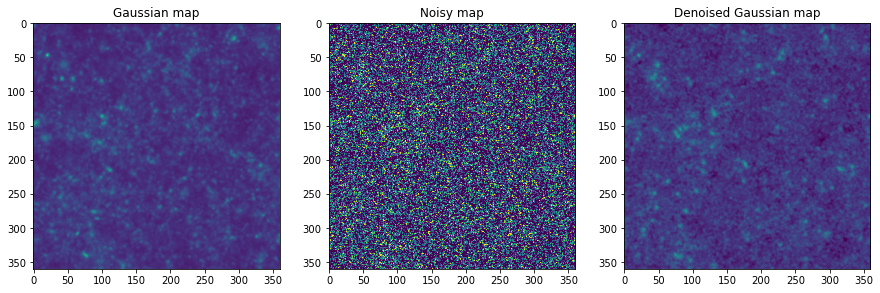

i: 1
Starting integration...
integration done...
i: 2
Starting integration...
integration done...
i: 3
Starting integration...
integration done...
i: 4
Starting integration...
integration done...
i: 5
Starting integration...
integration done...
i: 6
Starting integration...
integration done...
i: 7
Starting integration...
integration done...
i: 8
Starting integration...
integration done...
i: 9
Starting integration...
integration done...
i: 10
Starting integration...
integration done...


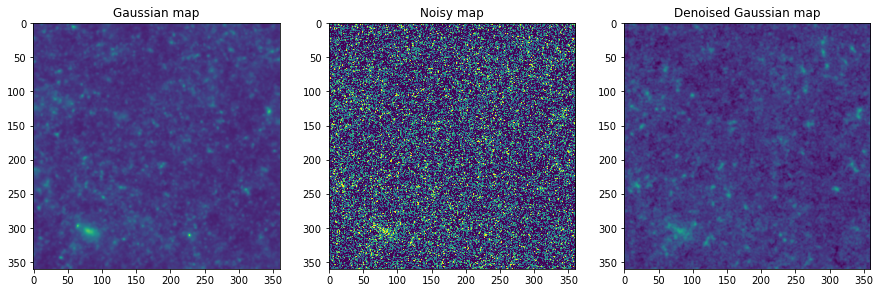

i: 11
Starting integration...
integration done...
i: 12
Starting integration...
integration done...
i: 13
Starting integration...
integration done...
i: 14
Starting integration...
integration done...
i: 15
Starting integration...
integration done...
i: 16
Starting integration...
integration done...
i: 17
Starting integration...
integration done...
i: 18
Starting integration...
integration done...
i: 19
Starting integration...
integration done...
i: 20
Starting integration...
integration done...


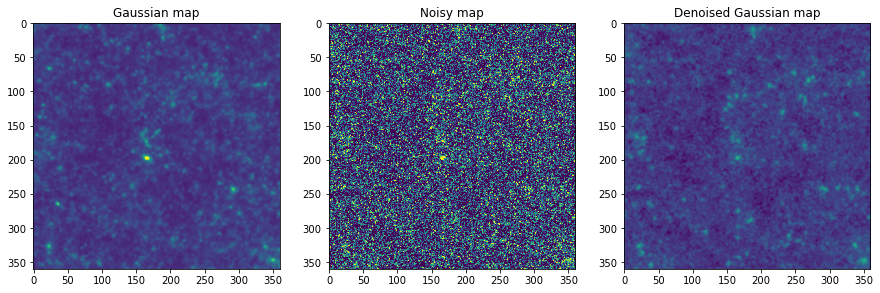

i: 21
Starting integration...
integration done...
i: 22
Starting integration...
integration done...
i: 23
Starting integration...
integration done...
i: 24
Starting integration...
integration done...
i: 25
Starting integration...
integration done...
i: 26
Starting integration...
integration done...
i: 27
Starting integration...
integration done...
i: 28
Starting integration...
integration done...
i: 29
Starting integration...
integration done...
i: 30
Starting integration...
integration done...


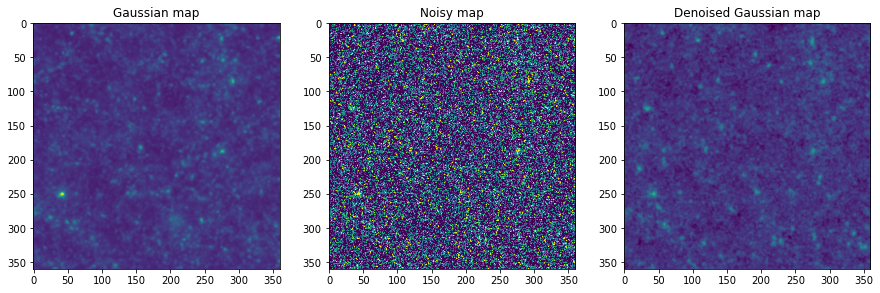

i: 31
Starting integration...
integration done...
i: 32
Starting integration...
integration done...
i: 33
Starting integration...
integration done...
i: 34
Starting integration...
integration done...
i: 35
Starting integration...
integration done...
i: 36
Starting integration...
integration done...
i: 37
Starting integration...
integration done...
i: 38
Starting integration...
integration done...
i: 39
Starting integration...
integration done...
i: 40
Starting integration...
integration done...


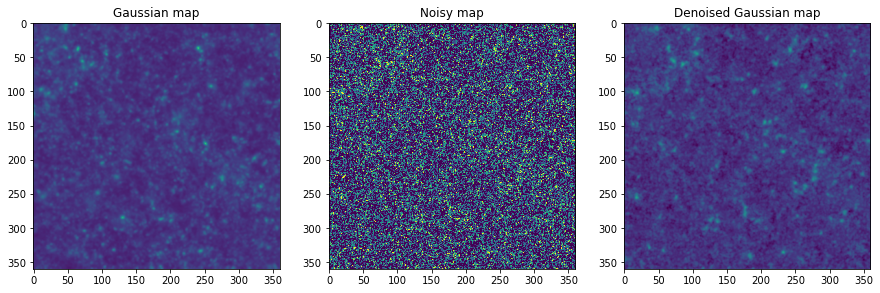

i: 41
Starting integration...
integration done...
i: 42
Starting integration...
integration done...
i: 43
Starting integration...
integration done...
i: 44
Starting integration...
integration done...
i: 45
Starting integration...
integration done...
i: 46
Starting integration...
integration done...
i: 47
Starting integration...
integration done...
i: 48
Starting integration...
integration done...
i: 49
Starting integration...
integration done...


In [188]:
gaussian_summary_list = []
sampled_summary_list = []

noise = 0.2

for i in range(50):
    print("i: %d"%(i))
    
    savename = None
#     gaussian_map_obj = get_Gaussian_map()
#     true_gaussian_map = gaussian_map_obj.data
    
    m = next(dset)
    true_gaussian_map = m['x'][0,...,0]
    gaussian_map_obj = ConvergenceMap(true_gaussian_map, angle)
    
    noisy_map = true_gaussian_map[jnp.newaxis,...,jnp.newaxis] + noise * randn(1,N_map,N_map,1)
    sampled_map = get_denoised_map(noisy_map[0,...,0], noise)
    
    sampled_map_obj = ConvergenceMap(sampled_map, angle).smooth(smoothing_scale)
    gaussian_map_obj = gaussian_map_obj.smooth(smoothing_scale)
    
    maps = [gaussian_map_obj.data, 
            noisy_map[0,...,0], None, sampled_map_obj.data]
    
    if(i%10==0):
#         savename = 'figs/DM_score/gauss_maps_hybrid_0.50/%d.png'%(i//10)
        plot_denoising_map(maps, savename)
    
    gaussian_summary = get_summary_stats(gaussian_map_obj)
    sampled_summary = get_summary_stats(sampled_map_obj)
    
    sampled_summary_list.append(sampled_summary)
    gaussian_summary_list.append(gaussian_summary)
#     plot_1pt_ps(maps)

In [189]:
gaussian_summary_stats_fname = 'dm_score/medium/summary_stats/0.20_massivenu/gauss.h5'
sampled_summary_stats_fname  = 'dm_score/medium/summary_stats/0.20_massivenu/denoised.h5'

In [190]:
import h5py as h5
def save_summary_stats(summary_list, filename):
    N_samples = len(summary_list)
    
    Cl_list = []
    pdf_list = []
    peak_counts_list = []
    MF_list = []
    
    for i in range(N_samples):
        Cl_data, pdf_data, peak_data, MF_data = summary_list[i]
        ell, Cl = Cl_data
        kappa_bin_centre, pdf = pdf_data
        peak_thresholds, peak_counts = peak_data
        MF_threshold, V0, V1, V2 = MF_data

        Cl_list.append(Cl)
        pdf_list.append(pdf)
        peak_counts_list.append(peak_counts)
        MF_list.append(np.array([V0, V1, V2]))
        
    with h5.File(filename, 'w') as f: 
        f['ell'] = ell
        f['Cl'] = np.array(Cl_list)
        
        f['kappa_pdf'] = kappa_bin_centre
        f['pdf'] = np.array(pdf_list)
        
        f['peak_threshold'] = peak_thresholds
        f['peak_counts'] = np.array(peak_counts_list)
        
        f['MF_thresholds'] = MF_threshold
        f['MF'] = np.array(MF_list)

In [191]:
save_summary_stats(gaussian_summary_list, gaussian_summary_stats_fname)
save_summary_stats(sampled_summary_list, sampled_summary_stats_fname)